# Rebate Recommendation Engine: Data Integration & Cleaning

In [1]:

# --- Core Libraries ---
import pandas as pd
import numpy as np
from datetime import datetime

# --- Data Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Fuzzy Matching ---
from thefuzz import process, fuzz

# --- Recommendation Model Libraries ---
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

# --- Geocoding and Deployment Libraries ---
from geopy.geocoders import Nominatim
import time
import pickle
import os
from collections import Counter

# --- Set Global Styles ---
plt.style.use('seaborn-v0_8-whitegrid')

print("All required libraries imported successfully.")

All required libraries imported successfully.


## Phase 1.1: Initial Data Preparation (Landscape)
This section loads the core **Application List** and **Appliance Hardware** datasets, cleans them, and merges them into `cleaned_master_data.csv`.

In [2]:
print("\n--- Starting Data Preparation ---")
print("This pipeline now includes both Application List.csv and Current Landscape Rebates.csv")
print("Special handling: 2025 customers are retained even with blank RebateType\n")

# Load Data - Application List and Current Landscape Rebates
try:
    df_app = pd.read_csv('Application List.csv', low_memory=False, on_bad_lines='skip', encoding='utf-8', quoting=1, engine='python')
    print(f"Loaded Application List with {len(df_app)} initial rows.")
except Exception as e:
    print(f"Error loading Application List.csv: {e}")
    try:
        # Try with different encoding and more aggressive error handling
        df_app = pd.read_csv('Application List.csv', low_memory=False, on_bad_lines='skip', encoding='latin-1', quoting=1, engine='python', error_bad_lines=False)
        print(f"Loaded Application List with {len(df_app)} initial rows (using latin-1 encoding).")
    except Exception as e2:
        print(f"Failed to load Application List.csv with both encodings: {e2}")
        try:
            # Final fallback with minimal parsing
            df_app = pd.read_csv('Application List.csv', on_bad_lines='skip', encoding='utf-8', sep=',', quotechar='"', engine='python', skipinitialspace=True)
            print(f"Loaded Application List with {len(df_app)} initial rows (using fallback parsing).")
        except Exception as e3:
            print(f"All CSV parsing attempts failed: {e3}")
            raise e3

# Load Current Landscape Rebates (2025 data) if available
try:
    df_current = pd.read_csv('Current Landscape Rebates.csv', on_bad_lines='skip', encoding='utf-8', quoting=1, engine='python')
    print(f"Loaded Current Landscape Rebates with {len(df_current)} rows.")
    
    # Ensure both dataframes have the same columns for concatenation
    # Get common columns between both datasets
    common_columns = list(set(df_app.columns).intersection(set(df_current.columns)))
    print(f"Found {len(common_columns)} common columns between datasets.")
    
    # Combine the datasets
    df_app_subset = df_app[common_columns]
    df_current_subset = df_current[common_columns]
    df_app = pd.concat([df_app_subset, df_current_subset], ignore_index=True)
    
    print(f"Combined dataset now has {len(df_app)} total rows.")
    
except FileNotFoundError:
    print("Current Landscape Rebates.csv not found - using only Application List.csv")
except Exception as e:
    print(f"Warning: Could not load Current Landscape Rebates.csv: {e}")
    print("Proceeding with only Application List.csv")

# Clean Application List - Apply different status filters by year
VALID_STATUSES_HISTORICAL = ['Appl. Received Complete', 'Check Issued', 'Past Rebate', 'Ready to be Paid']
VALID_STATUSES_2025 = ['Appl. Received Complete', 'Check Issued', 'Past Rebate', 'Ready to be Paid', 
                       'Notice to Proceed Sent', 'Post Insp. Approved']

# Convert Request Date early for year-based filtering
# Robustly handle multiple date formats (MM/DD/YYYY, YYYY-MM-DD, etc.)
from datetime import datetime

def robust_parse_date(date_str):
    for fmt in ("%Y-%m-%d", "%m/%d/%Y", "%Y/%m/%d", "%d-%b-%Y"):
        try:
            return datetime.strptime(str(date_str), fmt)
        except (ValueError, TypeError):
            continue
    try:
        # Try pandas' parser as fallback, but only on the single string
        return pd.to_datetime(str(date_str), errors='coerce')
    except Exception:
        return pd.NaT

parsed_dates = df_app['Request Date'].apply(robust_parse_date)
df_app['Request Date'] = parsed_dates
df_app.dropna(subset=['Request Date'], inplace=True)
print(f"Parsed {len(df_app)} valid Request Dates out of {len(parsed_dates)} rows.")

# Separate data by year for different status filtering
df_app['Request Year'] = df_app['Request Date'].dt.year
df_2025_plus = df_app[df_app['Request Year'] >= 2025].copy()
df_historical = df_app[df_app['Request Year'] < 2025].copy()

# Apply appropriate status filters
df_2025_cleaned = df_2025_plus[df_2025_plus['Rebate Status'].isin(VALID_STATUSES_2025)].copy()
df_historical_cleaned = df_historical[df_historical['Rebate Status'].isin(VALID_STATUSES_HISTORICAL)].copy()

# Combine back together
df_cleaned = pd.concat([df_historical_cleaned, df_2025_cleaned], ignore_index=True)
df_cleaned.drop('Request Year', axis=1, inplace=True)

print(f"Historical data: {len(df_historical_cleaned)} rows (strict status filter)")
print(f"2025+ data: {len(df_2025_cleaned)} rows (expanded status filter)")
# Request Date already converted and cleaned above
# Allow future dates for 2025 data (some may have future dates due to data entry)
# but filter out obviously erroneous future dates (beyond current year + 1)
current_year = datetime.now().year
max_allowed_date = datetime(current_year + 1, 12, 31)
df_cleaned = df_cleaned[df_cleaned['Request Date'] <= max_allowed_date]
df_cleaned['Site Zip Code'] = df_cleaned['Site Zip Code'].astype(str).str.split('.').str[0].str.zfill(5)
df_cleaned['City'] = df_cleaned['City'].str.strip().str.title()
print(f"After initial cleaning, {len(df_cleaned)} rows remain.")

# ---Remove rows with missing RebateType (except for 2025 data) ---
initial_rows_nan = len(df_cleaned)

# For 2025 data, keep all customers even if RebateType is blank
# For older years, remove rows with missing RebateType as before
df_cleaned['Request Year'] = df_cleaned['Request Date'].dt.year

# Separate 2025 data from older data
df_2025 = df_cleaned[df_cleaned['Request Year'] >= 2025].copy()
df_older = df_cleaned[df_cleaned['Request Year'] < 2025].copy()

# Apply RebateType filter only to older data
df_older.dropna(subset=['RebateType'], inplace=True)

# Combine back together
df_cleaned = pd.concat([df_older, df_2025], ignore_index=True)

# Drop the temporary year column
df_cleaned.drop('Request Year', axis=1, inplace=True)

final_rows_nan = len(df_cleaned)
print(f"Removed {initial_rows_nan - final_rows_nan} rows with missing RebateType (preserved 2025 data).")
print(f"2025 customers retained: {len(df_2025)} (including those with blank RebateType)")
if len(df_2025) > 0:
    print(f"2025 date range: {df_2025['Request Date'].min()} to {df_2025['Request Date'].max()}")
    blank_rebate_2025 = df_2025['RebateType'].isna().sum()
    print(f"2025 customers with blank RebateType: {blank_rebate_2025}")

# ---Deduplicate by Rebate Number ---
# This ensures each rebate application is a single, unique record.
initial_rows_dup = len(df_cleaned)
df_cleaned.drop_duplicates(subset=['Rebate Number'], keep='first', inplace=True)
final_rows_dup = len(df_cleaned)
print(f"Removed {initial_rows_dup - final_rows_dup} duplicate rebate number entries.")
print(f"Final dataset has {final_rows_dup} unique rebate applications.")

# Check 2025 data inclusion
final_2025_count = len(df_cleaned[df_cleaned['Request Date'].dt.year >= 2025])
print(f"Final dataset includes {final_2025_count} applications from 2025 or later.")

# Save Cleaned Data
# We select only the columns that exist in the dataframe to avoid errors.
final_columns = ['APN', 'Rebate Number', 'Site ID', 'Customer Name', 'Email Address', 'Site Type', 'City', 'Site Zip Code', 'Request Date', 'Rebate Status', 'RebateType']
final_columns_exist = [col for col in final_columns if col in df_cleaned.columns]
master_df_final = df_cleaned[final_columns_exist]

output_path = 'cleaned_master_data.csv'
master_df_final.to_csv(output_path, index=False)
print(f"Cleaned and deduplicated data saved to '{output_path}'.")


--- Starting Data Preparation ---
This pipeline now includes both Application List.csv and Current Landscape Rebates.csv
Special handling: 2025 customers are retained even with blank RebateType

Error loading Application List.csv: The 'low_memory' option is not supported with the 'python' engine
Failed to load Application List.csv with both encodings: read_csv() got an unexpected keyword argument 'error_bad_lines'
Loaded Application List with 20000 initial rows (using fallback parsing).


Loaded Current Landscape Rebates with 49 rows.
Found 25 common columns between datasets.
Combined dataset now has 20049 total rows.


Parsed 20049 valid Request Dates out of 20049 rows.
Historical data: 15529 rows (strict status filter)
2025+ data: 47 rows (expanded status filter)
After initial cleaning, 15574 rows remain.


Removed 385 rows with missing RebateType (preserved 2025 data).
2025 customers retained: 45 (including those with blank RebateType)
2025 date range: 2025-06-12 00:00:00 to 2025-06-25 00:00:00
2025 customers with blank RebateType: 27
Removed 0 duplicate rebate number entries.
Final dataset has 15189 unique rebate applications.
Final dataset includes 45 applications from 2025 or later.
Cleaned and deduplicated data saved to 'cleaned_master_data.csv'.


## Phase 1.2: Include All Graywater Customers
This critical step ensures that ALL graywater rebate participants are included in the master dataset, not just those who also participated in landscape rebates. This prevents the exclusion of graywater-only customers from the recommendation engine and analytics.

In [3]:
print("\n--- Including All Graywater Customers ---")
print("This step ensures graywater-only customers are included in the master dataset.")

# Load graywater data
try:
    df_graywater = pd.read_csv('Graywater Rebate.csv', low_memory=False, on_bad_lines='skip', encoding='utf-8', quoting=1, engine='python')
    print(f"Loaded {len(df_graywater)} graywater customers.")
except Exception as e:
    print(f"Error loading Graywater Rebate.csv: {e}")
    try:
        # Try with different encoding and more aggressive error handling
        df_graywater = pd.read_csv('Graywater Rebate.csv', low_memory=False, on_bad_lines='skip', encoding='latin-1', quoting=1, engine='python', error_bad_lines=False)
        print(f"Loaded {len(df_graywater)} graywater customers (using latin-1 encoding).")
    except Exception as e2:
        print(f"Failed to load Graywater Rebate.csv with both encodings: {e2}")
        try:
            # Final fallback with minimal parsing
            df_graywater = pd.read_csv('Graywater Rebate.csv', on_bad_lines='skip', encoding='utf-8', sep=',', quotechar='"', engine='python', skipinitialspace=True)
            print(f"Loaded {len(df_graywater)} graywater customers (using fallback parsing).")
        except Exception as e3:
            print(f"All graywater CSV parsing attempts failed: {e3}")
            df_graywater = pd.DataFrame()  # Empty dataframe if file not found

if not df_graywater.empty:
    # Load current master data
    df_master = pd.read_csv('cleaned_master_data.csv', low_memory=False)
    print(f"Current master data has {len(df_master)} records.")
    
    # Create standardized match strings for comparison
    def standardize_text(text):
        return str(text).lower().strip() if pd.notna(text) else ''
    
    # Create match strings for existing master data
    df_master['temp_match_string'] = df_master['Customer Name'].apply(standardize_text) + ' ' + df_master.get('Address/Site', df_master.get('City', '')).apply(standardize_text)
    
    # Create match strings for graywater data
    df_graywater['temp_match_string'] = df_graywater['Customer Name'].apply(standardize_text) + ' ' + df_graywater['Installation Address'].apply(standardize_text)
    
    # Find graywater customers NOT already in master data
    existing_matches = set(df_master['temp_match_string'].tolist())
    graywater_only = df_graywater[~df_graywater['temp_match_string'].isin(existing_matches)].copy()
    
    print(f"Found {len(graywater_only)} graywater-only customers to add.")
    
    if len(graywater_only) > 0:
        # Create new records for graywater-only customers
        new_records = []
        
        for _, gw_customer in graywater_only.iterrows():
            # Generate a unique rebate number for graywater-only customers
            # Use LRP Rebate Number if available, otherwise generate one
            rebate_number = gw_customer.get('LRP Rebate Number', f"GW_{gw_customer.get('Rebate Number', 'UNKNOWN')}")
            
            # Create new record with available graywater data
            # Fix Site ID assignment: use Rebate Number if Site ID is missing/blank
            site_id = gw_customer.get('Site ID', '')
            if not site_id or pd.isna(site_id) or str(site_id).strip() == '':
                site_id = str(gw_customer.get('Rebate Number', ''))
            
            new_record = {
                'Rebate Number': rebate_number,
                'Site ID': site_id,  # Now guaranteed to be non-blank
                'Customer Name': gw_customer.get('Customer Name', ''),
                'Site Type': gw_customer.get('Site Type', ''),
                'City': gw_customer.get('City', ''),
                'Site Zip Code': str(gw_customer.get('Zip Code', '')).split('.')[0] if pd.notna(gw_customer.get('Zip Code')) else '',
                'Request Date': gw_customer.get('Application Date', ''),
                'Rebate Status': gw_customer.get('Status', 'Graywater Program'),
                'RebateType': 'G',  # G for Graywater
                'Email Address': gw_customer.get('Email', ''),  # This is the key benefit!
            }
            
            # Add any other columns that exist in master data with empty values
            for col in df_master.columns:
                if col not in new_record and col != 'temp_match_string':
                    new_record[col] = ''
            
            new_records.append(new_record)
        
        # Convert to DataFrame and append to master data
        df_new_graywater = pd.DataFrame(new_records)
        
        # Remove temporary match string columns
        df_master.drop('temp_match_string', axis=1, inplace=True)
        
        # Ensure column alignment
        for col in df_master.columns:
            if col not in df_new_graywater.columns:
                df_new_graywater[col] = ''
        
        # Reorder columns to match master data
        df_new_graywater = df_new_graywater[df_master.columns]
        
        # Append graywater-only customers to master data
        df_master_enhanced = pd.concat([df_master, df_new_graywater], ignore_index=True)
        
        # Save enhanced master data
        df_master_enhanced.to_csv('cleaned_master_data.csv', index=False)
        
        print(f"Added {len(new_records)} graywater-only customers to master data.")
        print(f"Enhanced master data now has {len(df_master_enhanced)} total records.")
        print(f"Graywater-only customers will have 'RebateType' = 'G' and populated email addresses.")
    else:
        print("No additional graywater-only customers found.")
else:
    print("No graywater data available - skipping graywater inclusion.")



--- Including All Graywater Customers ---
This step ensures graywater-only customers are included in the master dataset.
Error loading Graywater Rebate.csv: The 'low_memory' option is not supported with the 'python' engine
Failed to load Graywater Rebate.csv with both encodings: read_csv() got an unexpected keyword argument 'error_bad_lines'
Loaded 174 graywater customers (using fallback parsing).
Current master data has 15189 records.
Found 174 graywater-only customers to add.
Added 174 graywater-only customers to master data.
Enhanced master data now has 15363 total records.
Graywater-only customers will have 'RebateType' = 'G' and populated email addresses.


## Phase 1.3: Graywater Integration - Direct Match Attempt
This section attempts to find overlap between the landscape and graywater datasets using direct identifier matching (`Rebate Number`, `LRP Rebate Number`).

In [4]:
print("\n--- Graywater Rebate Overlap Investigation ---")

# Load datasets
try:
    df_master = pd.read_csv('cleaned_master_data.csv', low_memory=False)
    df_graywater = pd.read_csv('Graywater Rebate.csv', low_memory=False)
except Exception as e:
    print(f"Error loading data: {e}")
    raise e

# Standardize keys
master_rebate_numbers = set(df_master['Rebate Number'].astype(str).str.strip().dropna())
graywater_rebate_numbers = set(df_graywater['Rebate Number'].astype(str).str.strip().dropna())
graywater_lrp_rebate_numbers = set(df_graywater['LRP Rebate Number'].astype(str).str.strip().dropna())

# Check for overlaps
print(f"Found {len(master_rebate_numbers.intersection(graywater_rebate_numbers))} matches on 'Rebate Number'.")
print(f"Found {len(master_rebate_numbers.intersection(graywater_lrp_rebate_numbers))} matches on 'LRP Rebate Number'.")


--- Graywater Rebate Overlap Investigation ---


Found 0 matches on 'Rebate Number'.
Found 42 matches on 'LRP Rebate Number'.


## Phase 1.3: Graywater Integration - Fuzzy Logic Matching
This section uses a fuzzy matching algorithm on customer names and addresses to find high-confidence links between the two datasets. It concludes by creating a `set` of matched rebate numbers for use in the next step.

In [5]:
print("\n--- Fuzzy Matching Analysis ---")

# Load raw datasets
try:
    df_landscape = pd.read_csv('Application List.csv', low_memory=False)
    df_graywater = pd.read_csv('Graywater Rebate.csv', low_memory=False)
except Exception as e:
    print(f"Error loading data: {e}")
    raise e

def standardize_text(text):
    return str(text).lower().strip() if pd.notna(text) else ''

df_landscape['match_string'] = df_landscape['Customer Name'].apply(standardize_text) + ' ' + df_landscape['Address/Site'].apply(standardize_text)
df_graywater['match_string'] = df_graywater['Customer Name'].apply(standardize_text) + ' ' + df_graywater['Installation Address'].apply(standardize_text)

landscape_choices = df_landscape['match_string'].tolist()
matches = []
email_matches = {}  # Dictionary to store rebate_number -> email mapping
match_threshold = 90

for idx, record in enumerate(df_graywater['match_string']):
    best_match = process.extractOne(record, landscape_choices, scorer=fuzz.token_sort_ratio)
    if best_match and best_match[1] >= match_threshold:
        matches.append(best_match[0])
        # Get the graywater record for this match to extract email
        graywater_record = df_graywater.iloc[idx]
        graywater_email = graywater_record.get('Email', '')
        
        # Find the corresponding landscape record to get rebate number
        landscape_match = df_landscape[df_landscape['match_string'] == best_match[0]]
        if not landscape_match.empty:
            rebate_number = str(landscape_match.iloc[0]['Rebate Number'])
            if pd.notna(graywater_email) and graywater_email.strip():
                email_matches[rebate_number] = graywater_email.strip()

print(f"Found {len(matches)} high-confidence matches.")
print(f"Extracted {len(email_matches)} email addresses for matched customers.")

matched_rebate_numbers = set()
if matches:
    landscape_lookup = df_landscape[df_landscape['match_string'].isin(matches)]
    matched_rebate_numbers = set(landscape_lookup['Rebate Number'].astype(str).dropna())
    print(f"Extracted {len(matched_rebate_numbers)} unique rebate numbers for integration.")



--- Fuzzy Matching Analysis ---


Found 42 high-confidence matches.
Extracted 37 email addresses for matched customers.
Extracted 43 unique rebate numbers for integration.


## Phase 1.4: Feature Engineering - Add Graywater Participation Flag
This final data preparation step uses the set of matched rebate numbers from the previous cell to create a new boolean feature, `participated_in_graywater`, in the master dataset.

In [6]:
print("\n--- Feature Engineering: Add Graywater Flag and Email Addresses ---")

if 'matched_rebate_numbers' not in locals():
    print("Error: 'matched_rebate_numbers' not found. Run fuzzy matching cell first.")
else:
    df_master = pd.read_csv('cleaned_master_data.csv', low_memory=False)
    df_master['Rebate Number'] = df_master['Rebate Number'].astype(str)
    
    # Add graywater participation flag
    df_master['participated_in_graywater'] = df_master['Rebate Number'].isin(matched_rebate_numbers)
    
    # Add Email Address column and populate from graywater matches
    df_master['Email Address'] = ''
    if 'email_matches' in locals():
        for rebate_num, email in email_matches.items():
            mask = df_master['Rebate Number'] == rebate_num
            df_master.loc[mask, 'Email Address'] = email
        
        emails_added = (df_master['Email Address'] != '').sum()
        print(f"Successfully added {emails_added} email addresses from graywater matches.")
    else:
        print("Warning: 'email_matches' not found. Email addresses will be empty.")
    
    df_master.to_csv('cleaned_master_data.csv', index=False)
    print(f"Successfully set 'participated_in_graywater' to True for {df_master['participated_in_graywater'].sum()} records.")



--- Feature Engineering: Add Graywater Flag and Email Addresses ---
Successfully added 0 email addresses from graywater matches.
Successfully set 'participated_in_graywater' to True for 0 records.


## Phase 1.5: Feature Engineering - Deconstruct RebateType
Based on the insight that the `RebateType` column contains codes for multiple sub-rebates, this step creates five new boolean (True/False) columns. Each new column corresponds to a specific sub-rebate, allowing the model to analyze the impact of each program individually. This is the final step in data preparation.

In [7]:
print("\n--- Feature Engineering: Deconstructing RebateType ---")

# Load the dataset enriched with the graywater flag
df_master = pd.read_csv('cleaned_master_data.csv', low_memory=False)

# Define the mapping from codes to full feature names and descriptions
rebate_mapping = {
    'W': 'has_wbic_rebate', # Weather Based Irrigation Controller
    'I': 'has_irrigation_upgrade_rebate', # Irrigation Equipment Upgrade
    'L': 'has_landscape_conversion_rebate', # Landscape Conversion
    'R': 'has_rainwater_capture_rebate', # Rainwater Capture
    'D': 'has_drip_conversion_rebate', # Drip Irrigation Conversion
    'G': 'has_graywater_rebate' # Graywater Rebate (for graywater-only customers)
}

print("Creating new boolean columns for each sub-rebate based on 'RebateType'...")
# Ensure RebateType is a string to allow for '.str.contains()'
df_master['RebateType'] = df_master['RebateType'].astype(str)

for code, new_col in rebate_mapping.items():
    df_master[new_col] = df_master['RebateType'].str.contains(code, na=False)
    print(f"  - Created '{new_col}' with {df_master[new_col].sum()} participants.")

# Add rebate_count column - sum of all six boolean rebate columns
rebate_cols_for_count = list(rebate_mapping.values()) + ['participated_in_graywater']
print(f"\nComputing rebate_count column from: {rebate_cols_for_count}")

# Ensure all rebate columns are boolean and handle any missing values
for col in rebate_cols_for_count:
    if col in df_master.columns:
        df_master[col] = df_master[col].fillna(False).astype(bool)
    else:
        print(f"Warning: Column '{col}' not found, treating as False for all rows.")
        df_master[col] = False

# Calculate rebate_count as the sum of True values across all rebate columns
df_master['rebate_count'] = df_master[rebate_cols_for_count].sum(axis=1)
print(f"  - Created 'rebate_count' column with values ranging from {df_master['rebate_count'].min()} to {df_master['rebate_count'].max()}")
print(f"  - Average rebates per customer: {df_master['rebate_count'].mean():.2f}")

# Save the final, fully-featured dataset
# Ensure all original and new columns are kept
output_path = 'cleaned_master_data.csv'
df_master.to_csv(output_path, index=False)

print(f"\nFully enriched master dataset saved to '{output_path}'.")
print("The dataset is now ready for Exploratory Data Analysis (EDA).")


--- Feature Engineering: Deconstructing RebateType ---
Creating new boolean columns for each sub-rebate based on 'RebateType'...
  - Created 'has_wbic_rebate' with 5742 participants.
  - Created 'has_irrigation_upgrade_rebate' with 4780 participants.
  - Created 'has_landscape_conversion_rebate' with 10390 participants.
  - Created 'has_rainwater_capture_rebate' with 128 participants.
  - Created 'has_drip_conversion_rebate' with 311 participants.
  - Created 'has_graywater_rebate' with 174 participants.

Computing rebate_count column from: ['has_wbic_rebate', 'has_irrigation_upgrade_rebate', 'has_landscape_conversion_rebate', 'has_rainwater_capture_rebate', 'has_drip_conversion_rebate', 'has_graywater_rebate', 'participated_in_graywater']
  - Created 'rebate_count' column with values ranging from 0 to 5
  - Average rebates per customer: 1.40

Fully enriched master dataset saved to 'cleaned_master_data.csv'.
The dataset is now ready for Exploratory Data Analysis (EDA).


# Phase 2: Exploratory Data Analysis (EDA)

## Phase 2.1: Rebate Program Popularity and Distribution
**Objective:** Understand the baseline popularity of each rebate to inform our cold-start strategy and identify niche programs.

--- EDA: Analyzing Rebate Popularity ---


Loaded dataset with 15363 rows.

Summary Statistics for Rebate Participation:
has_landscape_conversion_rebate    10390
has_wbic_rebate                     5742
has_irrigation_upgrade_rebate       4780
has_drip_conversion_rebate           311
has_graywater_rebate                 174
has_rainwater_capture_rebate         128
participated_in_graywater              0
dtype: int64


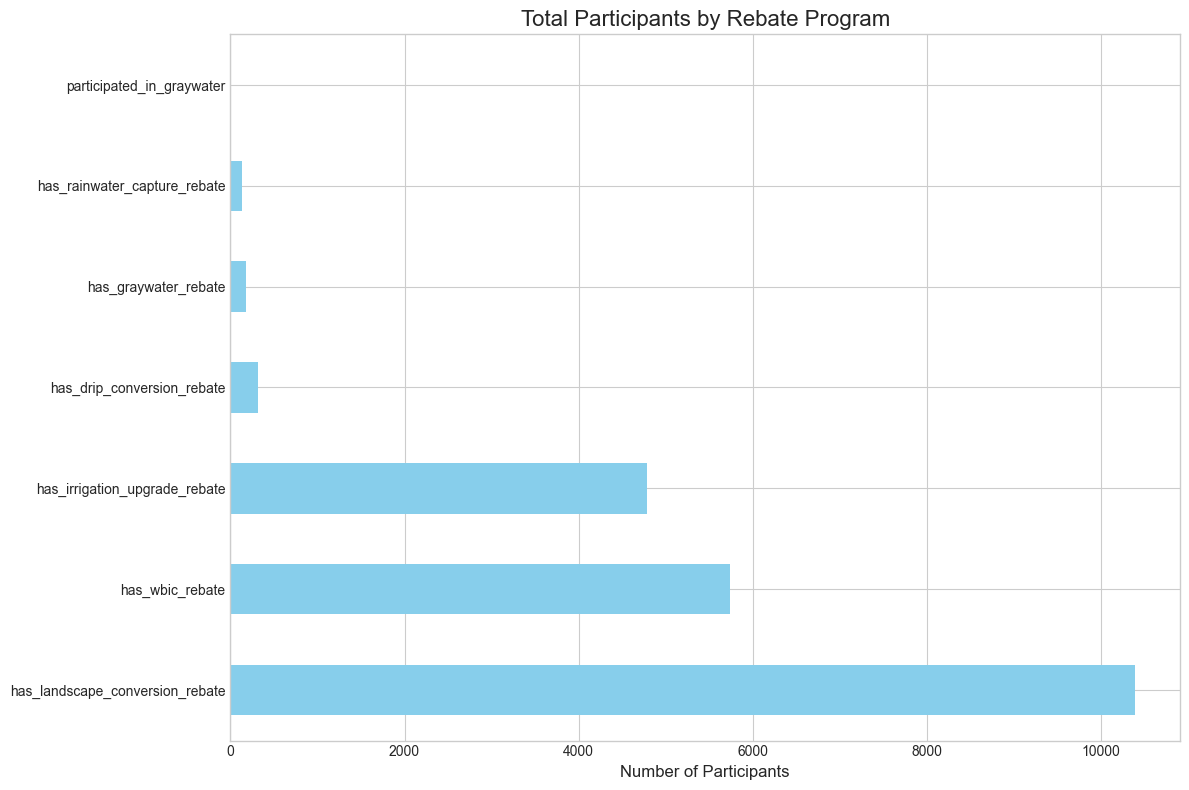

In [8]:
print("--- EDA: Analyzing Rebate Popularity ---")
# Load the fully-featured dataset
df = pd.read_csv('cleaned_master_data.csv', low_memory=False)
print(f"Loaded dataset with {len(df)} rows.")

# Analyze and plot rebate participation
print("\nSummary Statistics for Rebate Participation:")
rebate_cols = [col for col in df.columns if col.startswith('has_') or col == 'participated_in_graywater']
participation_counts = df[rebate_cols].sum().sort_values(ascending=False)
print(participation_counts)

plt.figure(figsize=(12, 8))
participation_counts.plot(kind='barh', color='skyblue')
plt.title('Total Participants by Rebate Program', fontsize=16)
plt.xlabel('Number of Participants', fontsize=12)
plt.tight_layout()
plt.show()

## Phase 2.2: Geographic Pattern Analysis
**Objective:** Validate the geographic similarity hypothesis by identifying "hotspots" of rebate activity.


--- EDA: Analyzing Geographic Patterns ---
Top 15 Participating Cities:
City
San Jose           6897
Sunnyvale          1150
Palo Alto          1117
Santa Clara         921
Cupertino           852
Saratoga            760
Mountain View       622
Morgan Hill         576
Los Gatos           496
Los Altos           490
Campbell            464
Gilroy              355
Milpitas            355
Los Altos Hills     124
Monte Sereno         76
Name: count, dtype: int64


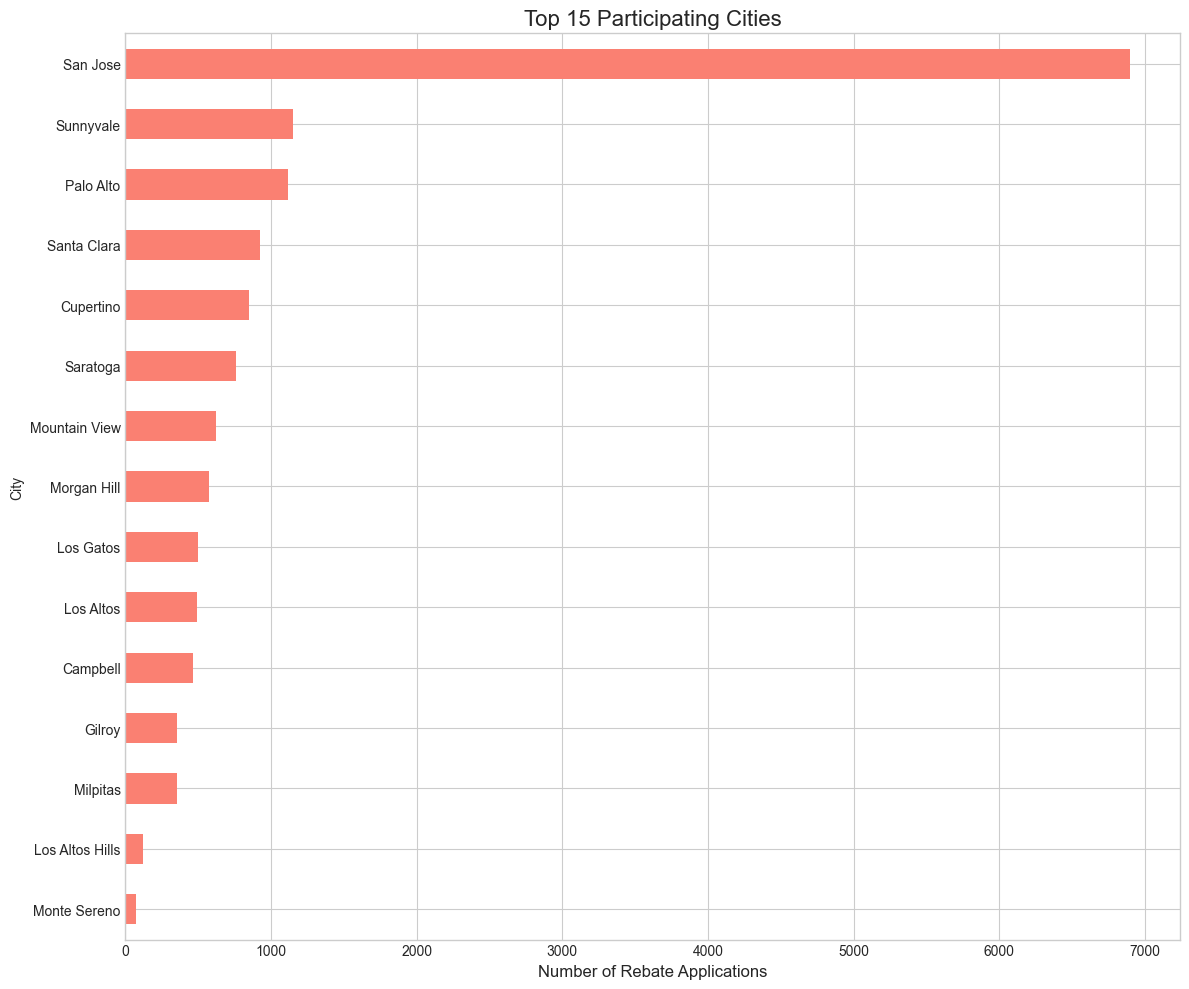

In [9]:
print("\n--- EDA: Analyzing Geographic Patterns ---")
print("Top 15 Participating Cities:")
top_cities = df['City'].value_counts().nlargest(15)
print(top_cities)

plt.figure(figsize=(12, 10))
top_cities.plot(kind='barh', color='salmon')
plt.title('Top 15 Participating Cities', fontsize=16)
plt.xlabel('Number of Rebate Applications', fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Phase 2.3: Rebate Co-occurrence and Correlation
**Objective:** Discover natural "bundles" of rebates that are frequently adopted together, which is the foundation for collaborative filtering.


--- EDA: Analyzing Rebate Co-occurrence ---


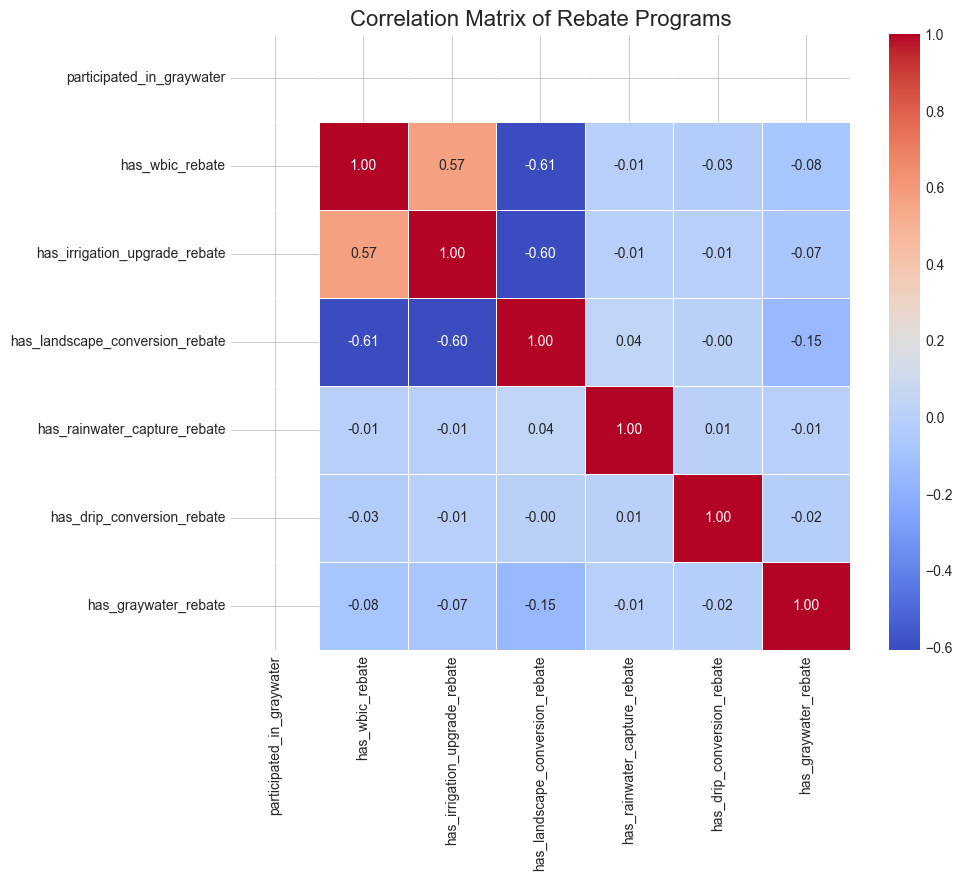

In [10]:
print("\n--- EDA: Analyzing Rebate Co-occurrence ---")
rebate_cols = [col for col in df.columns if col.startswith('has_') or col == 'participated_in_graywater']
correlation_matrix = df[rebate_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Rebate Programs', fontsize=16)
plt.show()

## Phase 2.4: Analysis by Customer Segment (Site Type)
**Objective:** Ensure recommendations are personalized by analyzing the unique preferences of different customer segments (e.g., Single Family vs. Commercial).


--- EDA: Analyzing by Site Type ---


               participated_in_graywater  has_wbic_rebate  \
Site Type                                                   
Commercial                             0              188   
Industrial                             0               15   
Institutional                          0               93   
MFD                                    0              237   
Single Family                          0             5209   

               has_irrigation_upgrade_rebate  has_landscape_conversion_rebate  \
Site Type                                                                       
Commercial                               201                              306   
Industrial                                17                               34   
Institutional                             65                               68   
MFD                                      247                              459   
Single Family                           4250                             9523   

    

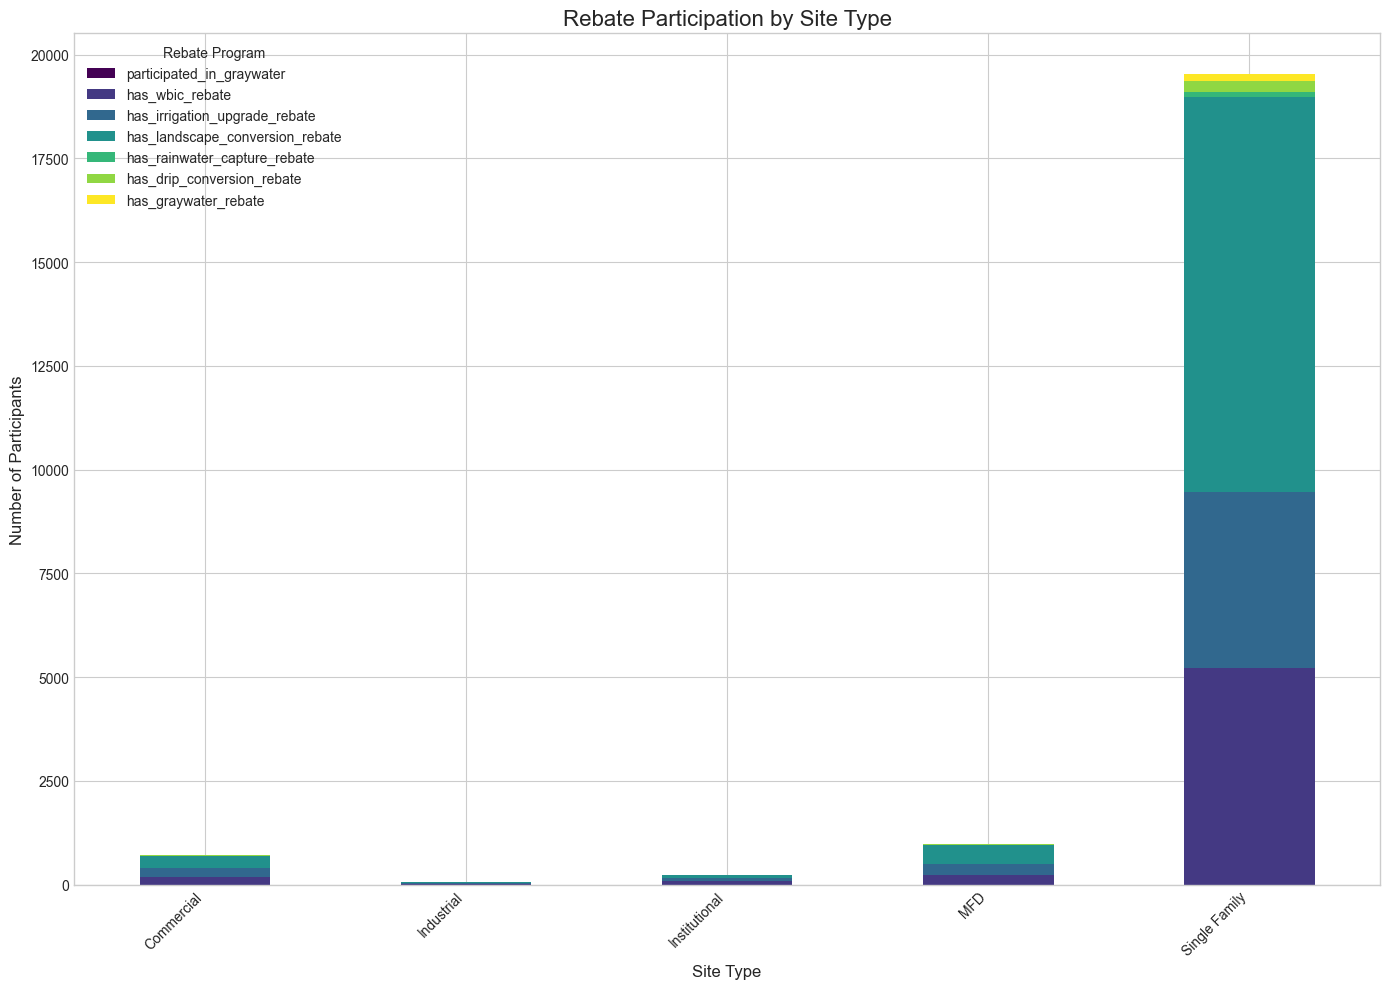

In [11]:
print("\n--- EDA: Analyzing by Site Type ---")
rebate_cols = [col for col in df.columns if col.startswith('has_') or col == 'participated_in_graywater']
site_type_analysis = df.groupby('Site Type')[rebate_cols].sum()
print(site_type_analysis)

# Plotting the analysis
site_type_analysis.plot(kind='bar', stacked=True, figsize=(14, 10), colormap='viridis')
plt.title('Rebate Participation by Site Type', fontsize=16)
plt.ylabel('Number of Participants', fontsize=12)
plt.xlabel('Site Type', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Rebate Program')
plt.tight_layout()
plt.show()

# Phase 3: Baseline Recommendation Model
**Objective:** Build a baseline recommendation engine using the insights from the EDA. This model will use a hybrid, rule-based approach combining content-based, collaborative, and popularity-based filtering to generate personalized recommendations.

In [12]:
print("--- Defining Baseline Recommendation Model ---")

# Ensure data is loaded for model use
df = pd.read_csv('cleaned_master_data.csv', low_memory=False)
rebate_cols = [col for col in df.columns if col.startswith('has_') or col == 'participated_in_graywater']

# --- Create a mapping for human-readable names ---
rebate_name_map = {
    'has_drip_conversion_rebate': 'Drip Conversion Rebate',
    'has_irrigation_upgrade_rebate': 'Irrigation Upgrade Rebate',
    'has_landscape_conversion_rebate': 'Landscape Conversion Rebate',
    'has_rainwater_capture_rebate': 'Rainwater Capture Rebate',
    'has_wbic_rebate': 'WBIC Rebate',
    'has_graywater_rebate': 'Graywater Rebate',
    'participated_in_graywater': 'Graywater Rebate'
}

# --- Pre-calculate Popularity Metrics for efficiency ---
# 1. Overall popularity
overall_popularity = df[rebate_cols].sum()

# 2. Geographic popularity (by city)
city_popularity = df.groupby('City')[rebate_cols].sum()

# 3. Site Type popularity
site_type_popularity = df.groupby('Site Type')[rebate_cols].sum()

def get_recommendations(customer_data, n=5):
    '''
    Generates rebate recommendations for a single customer based on EDA insights,
    including the reasons for each recommendation.
    '''
    recommendations = {}
    customer_rebates = {col for col in rebate_cols if customer_data[col] == 1}
    customer_city = customer_data['City']
    customer_site_type = customer_data['Site Type']

    # --- 1. Add correlated rebates ---
    for rebate in customer_rebates:
        correlated_series = correlation_matrix[rebate][correlation_matrix[rebate] > 0.4]
        for correlated_rebate in correlated_series.index:
            if correlated_rebate not in customer_rebates:
                if correlated_rebate not in recommendations:
                    recommendations[correlated_rebate] = {'score': 0, 'reasons': []}
                recommendations[correlated_rebate]['score'] += 3 # High boost for correlation
                recommendations[correlated_rebate]['reasons'].append(f"Correlates with '{rebate_name_map[rebate]}'")

    # --- 2. Add rebates popular by city ---
    if customer_city in city_popularity.index:
        city_popular_rebates = city_popularity.loc[customer_city].nlargest(3).index
        for rebate in city_popular_rebates:
            if rebate not in customer_rebates:
                if rebate not in recommendations:
                    recommendations[rebate] = {'score': 0, 'reasons': []}
                recommendations[rebate]['score'] += 2 # Medium boost for city
                recommendations[rebate]['reasons'].append(f"Popular in your city ({customer_city})")

    # --- 3. Add rebates popular by site type ---
    if customer_site_type in site_type_popularity.index:
        site_type_popular_rebates = site_type_popularity.loc[customer_site_type].nlargest(2).index
        for rebate in site_type_popular_rebates:
            if rebate not in customer_rebates:
                if rebate not in recommendations:
                    recommendations[rebate] = {'score': 0, 'reasons': []}
                recommendations[rebate]['score'] += 1.5 # Lower boost for site type
                recommendations[rebate]['reasons'].append(f"Popular for your site type ({customer_site_type})")

    # --- 4. Content-based filtering ---
    if customer_site_type != 'Single Family':
        for rebate in ['participated_in_graywater', 'has_rainwater_capture_rebate']:
            if rebate in recommendations:
                del recommendations[rebate]

    # --- 5. Add overall popular rebates as a fallback ---
    overall_popular_rebates = overall_popularity.nlargest(5).index
    for rebate in overall_popular_rebates:
        if rebate not in customer_rebates and rebate not in recommendations:
            recommendations[rebate] = {'score': 1, 'reasons': ["Generally popular program"]}

    # --- 6. Format and sort the final list ---
    final_recs = [{'item_code': k, 'item': rebate_name_map[k], 'score': f"{v['score']:.2f}", 'reasons': v['reasons']} for k, v in recommendations.items()]
    final_recs.sort(key=lambda x: x['score'], reverse=True)
    
    return final_recs[:n]

print("Baseline recommendation model defined successfully.")

--- Defining Baseline Recommendation Model ---
Baseline recommendation model defined successfully.


In [13]:
print("\n--- Demonstrating Recommendation Model ---")

# Example 1: A Single Family home in San Jose with no rebates
query_1 = df[(df['Site Type'] == 'Single Family') & (df['City'] == 'San Jose') & (df[rebate_cols].sum(axis=1) == 0)]
if not query_1.empty:
    customer_1 = query_1.iloc[0]
    recs_1 = get_recommendations(customer_1)
    print(f"\nRecommendations for a new Single Family customer in {customer_1['City']}:\n{recs_1}")
else:
    print("\nCould not find a sample customer for Example 1 (SF, San Jose, no rebates).")

# Example 2: A Commercial property in Palo Alto that already has a WBIC rebate
query_2 = df[(df['Site Type'] == 'Commercial') & (df['City'] == 'Palo Alto') & (df['has_wbic_rebate'] == 1)]
if not query_2.empty:
    customer_2 = query_2.iloc[0]
    recs_2 = get_recommendations(customer_2)
    print(f"\nRecommendations for a Commercial customer in {customer_2['City']} with a WBIC rebate:\n{recs_2}")
else:
    print("\nCould not find a sample customer for Example 2 (Commercial, Palo Alto, WBIC rebate).")

# Example 3: A Single Family home in Saratoga that has a Landscape Conversion rebate
query_3 = df[(df['Site Type'] == 'Single Family') & (df['City'] == 'Saratoga') & (df['has_landscape_conversion_rebate'] == 1)]
if not query_3.empty:
    customer_3 = query_3.iloc[0]
    recs_3 = get_recommendations(customer_3)
    print(f"\nRecommendations for a Single Family customer in {customer_3['City']} with a Landscape Conversion rebate:\n{recs_3}")
else:
    print("\nCould not find a sample customer for Example 3 (SF, Saratoga, Landscape rebate).")


--- Demonstrating Recommendation Model ---

Recommendations for a new Single Family customer in San Jose:
[{'item_code': 'has_landscape_conversion_rebate', 'item': 'Landscape Conversion Rebate', 'score': '3.50', 'reasons': ['Popular in your city (San Jose)', 'Popular for your site type (Single Family)']}, {'item_code': 'has_wbic_rebate', 'item': 'WBIC Rebate', 'score': '3.50', 'reasons': ['Popular in your city (San Jose)', 'Popular for your site type (Single Family)']}, {'item_code': 'has_irrigation_upgrade_rebate', 'item': 'Irrigation Upgrade Rebate', 'score': '2.00', 'reasons': ['Popular in your city (San Jose)']}, {'item_code': 'has_drip_conversion_rebate', 'item': 'Drip Conversion Rebate', 'score': '1.00', 'reasons': ['Generally popular program']}, {'item_code': 'has_graywater_rebate', 'item': 'Graywater Rebate', 'score': '1.00', 'reasons': ['Generally popular program']}]

Recommendations for a Commercial customer in Palo Alto with a WBIC rebate:
[{'item_code': 'has_landscape_conv

# Phase 4: Advanced Recommendation Model (SVD)
This phase implements and evaluates a more sophisticated recommendation model using Singular Value Decomposition (SVD) to uncover latent features in the data.

## Verification Step: Check for Multi-Rebate Users
**Objective:** Verify that the dataset contains users who have participated in multiple rebates over time. This is essential for ensuring that the temporal train-test split is valid, as it requires users to be present in both the training period (past rebates) and the testing period (future rebates).

In [14]:

print("\n--- Verifying User Participation Counts ---")
df = pd.read_csv('cleaned_master_data.csv', low_memory=False)

user_participation_counts = df['Site ID'].value_counts()

multi_participation_users = user_participation_counts[user_participation_counts > 1]

print(f"Total unique users (Site IDs): {len(user_participation_counts)}")
print(f"Number of users with more than one rebate: {len(multi_participation_users)}")

if len(multi_participation_users) > 0:
    print("\nConclusion: The dataset correctly contains users with multiple interactions.")
    print("This confirms that the temporal train-test split is valid.")
else:
    print("\nCRITICAL WARNING: No users have multiple rebates. The evaluation logic is flawed.")



--- Verifying User Participation Counts ---


Total unique users (Site IDs): 14154
Number of users with more than one rebate: 1042

Conclusion: The dataset correctly contains users with multiple interactions.
This confirms that the temporal train-test split is valid.


## Phase 4.1: Data Preparation & Temporal Split
Here, we prepare the data for the `scikit-surprise` library. We perform a temporal split to train the model on past data and test it on future data, simulating a real-world deployment scenario.

In [15]:
print("--- Preparing Data for Advanced Model ---")

# Load the dataset
df = pd.read_csv('cleaned_master_data.csv', low_memory=False)

# Robustly parse 'Request Date' to handle mixed formats (MM/DD/YYYY, YYYY-MM-DD, etc.)
from datetime import datetime
def robust_parse_date(date_str):
    for fmt in ("%Y-%m-%d", "%m/%d/%Y", "%Y/%m/%d", "%d-%b-%Y"):
        try:
            return datetime.strptime(str(date_str), fmt)
        except (ValueError, TypeError):
            continue
    try:
        return pd.to_datetime(str(date_str), errors='coerce')
    except Exception:
        return pd.NaT
df['Request Date'] = df['Request Date'].apply(robust_parse_date)


# --- Create the user-item interaction data ---
# We need to melt the dataframe to get a user-item-rating format
rebate_cols = [
    'has_wbic_rebate', 'has_irrigation_upgrade_rebate', 'has_landscape_conversion_rebate',
    'has_drip_conversion_rebate', 'has_rainwater_capture_rebate', 'participated_in_graywater'
]

# Use Site ID as the user ID
user_item_df = df[['Site ID', 'Request Date'] + rebate_cols]

# Melt the dataframe to long format
interactions_df = user_item_df.melt(
    id_vars=['Site ID', 'Request Date'],
    value_vars=rebate_cols,
    var_name='item',
    value_name='rating'
)

# Keep only the interactions (rating == 1)
interactions_df = interactions_df[interactions_df['rating'] == 1].copy()

# --- User-based Train-Test Split: Ensure all test users are in train set ---
# For each user with >1 interaction, keep their most recent interaction as test, rest as train
interactions_df = interactions_df.sort_values(['Site ID', 'Request Date'])
train_rows = []
test_rows = []
for user_id, group in interactions_df.groupby('Site ID'):
    if len(group) > 1:
        # Most recent interaction for test, rest for train
        test_rows.append(group.iloc[-1])
        train_rows.extend(group.iloc[:-1].values)
    else:
        # Only one interaction: use for training only
        train_rows.extend(group.values)
train_df = pd.DataFrame(train_rows, columns=interactions_df.columns)
test_df = pd.DataFrame(test_rows, columns=interactions_df.columns)

print(f"Training set contains {len(train_df)} interactions.")
print(f"Test set contains {len(test_df)} interactions.")

# --- Format for Surprise Library ---
# The Reader object is needed to parse the file or dataframe
reader = Reader(rating_scale=(0, 1))

# The columns must be in the order: user, item, rating
# We select only the required columns for loading
train_data_surprise = Dataset.load_from_df(train_df[['Site ID', 'item', 'rating']], reader)

# Build the full training set from this data
trainset = train_data_surprise.build_full_trainset()

print("\nData successfully formatted for scikit-surprise and training set built.")

--- Preparing Data for Advanced Model ---


Training set contains 15829 interactions.
Test set contains 5522 interactions.

Data successfully formatted for scikit-surprise and training set built.


## Phase 4.2: Train SVD Model
With the data prepared, we now instantiate and train the SVD algorithm. The model will learn the latent factors from the training data.

In [16]:
print("--- Training SVD Model ---")

# Instantiate the SVD model
# These are some standard parameters; they can be tuned later.
svd_model = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)

# Train the model on the training set
svd_model.fit(trainset)

print("\nSVD model training complete.")

--- Training SVD Model ---

SVD model training complete.


## Phase 4.3: Hyperparameter Tuning with GridSearchCV
**Objective:** Systematically search for the best combination of hyperparameters for the SVD model to maximize its predictive accuracy.

In [17]:

from surprise.model_selection import GridSearchCV

print("\n--- Tuning SVD Hyperparameters ---")

# Define the parameter grid to search
param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [20, 30],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.1]
}

# Set up the grid search to run on the training set
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, joblib_verbose=2)

# Fit the data
gs.fit(train_data_surprise)

# Print the best score and parameters
print(f"\nBest RMSE score: {gs.best_score['rmse']:.4f}")
print(f"Best parameters for RMSE: {gs.best_params['rmse']}")

# Use the best model for the final evaluation
print("\nAssigning the best SVD model for evaluation...")
svd_model = gs.best_estimator['rmse']

# Now, train this best model on the full training set before evaluation
print("Training the optimized model on the full training set...")
svd_model.fit(trainset)
print("Optimized model is trained and ready for evaluation.")



--- Tuning SVD Hyperparameters ---


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.1s



Best RMSE score: 0.0006
Best parameters for RMSE: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}

Assigning the best SVD model for evaluation...
Training the optimized model on the full training set...
Optimized model is trained and ready for evaluation.


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    6.8s finished


## Phase 4.4: Multi-k Evaluation of SVD and Baseline Models
Evaluate both models for k=3, 4, and 5 using precision@k and recall@k. Results are summarized in a table below.


--- Evaluating SVD, Baseline, and Hybrid Models ---


   Model  k  Precision@k  Recall@k
Baseline  3     0.026711  0.080043
  Hybrid  3     0.300887  0.895690
     SVD  3     0.277647  0.825969
Baseline  4     0.022320  0.080043
  Hybrid  4     0.243843  0.895690
     SVD  4     0.243843  0.895690
Baseline  5     0.022320  0.080043
  Hybrid  5     0.243843  0.895690
     SVD  5     0.243843  0.895690


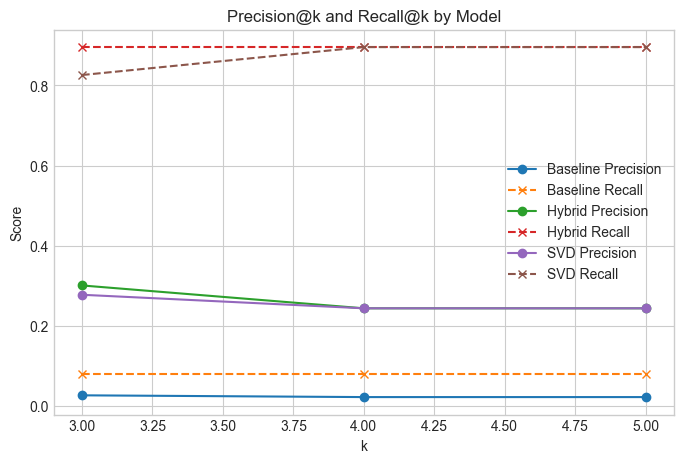

 User  Hits@5                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

Best hybrid boost params (city, site, corr): (0.5, 0.5, 1.0) with score=1.140


In [18]:
from collections import defaultdict
print("\n--- Evaluating SVD, Baseline, and Hybrid Models ---")

# --- Pre-computation for Hybrid Model Re-ranking ---
rebate_cols = [col for col in df.columns if col.startswith('has_') or col == 'participated_in_graywater']

# 1. Popularity by City
city_popularity = df.groupby('City')[rebate_cols].sum()

# 2. Popularity by Site Type
site_type_popularity = df.groupby('Site Type')[rebate_cols].sum()

# 3. Rebate Correlations
correlation_matrix = df[rebate_cols].corr()


# --- Evaluation Functions ---
results = []
k_values = [3, 4, 5]

def get_top_n(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n] # Keep scores for hybrid model
    return top_n

def precision_recall_at_k(predictions, actual, k):
    precisions = []
    recalls = []
    for user, recs in predictions.items():
        if user not in actual:
            continue
        # Ensure recs are just item IDs
        recs_items = [r[0] if isinstance(r, tuple) else r for r in recs]
        relevant = actual[user]
        recommended = set(recs_items)
        n_rel = len(relevant)
        n_rec_k = len(recommended)
        n_rel_and_rec_k = len(recommended & relevant)
        precisions.append(n_rel_and_rec_k / n_rec_k if n_rec_k else 0)
        recalls.append(n_rel_and_rec_k / n_rel if n_rel else 0)
    return np.mean(precisions), np.mean(recalls)


# --- Hybrid Model Logic ---
def get_hybrid_recommendations(svd_top_n, user_data):
    hybrid_recs = []
    user_city = user_data['City'].iloc[0]
    user_site_type = user_data['Site Type'].iloc[0]
    user_rebates_series = user_data[rebate_cols].iloc[0]
    user_rebates = set(user_rebates_series[user_rebates_series == 1].index)

    top_city_rebates = set(city_popularity.loc[user_city].nlargest(3).index) if user_city in city_popularity.index else set()
    top_site_type_rebates = set(site_type_popularity.loc[user_site_type].nlargest(2).index) if user_site_type in site_type_popularity.index else set()

    for item, svd_score in svd_top_n:
        hybrid_score = svd_score
        reasons = ["Good match based on participation history (SVD)"]
        
        if item in top_city_rebates:
            hybrid_score += 1.5
            reasons.append(f"Popular in your city ({user_city})")
        if item in top_site_type_rebates:
            hybrid_score += 1.0
            reasons.append(f"Popular for your site type ({user_site_type})")
        for existing_rebate in user_rebates:
            correlation = correlation_matrix.loc[existing_rebate, item]
            if correlation > 0.5:
                hybrid_score += 2.0
                reasons.append(f"Correlates with '{rebate_name_map[existing_rebate]}'")
            elif correlation < -0.3:
                hybrid_score -= 1.5
                reasons.append(f"Conflicts with '{rebate_name_map[existing_rebate]}' (negative correlation)")
        
        hybrid_recs.append({'item_code': item, 'item': rebate_name_map[item], 'score': f"{hybrid_score:.2f}", 'reasons': reasons})

    hybrid_recs.sort(key=lambda x: x['score'], reverse=True)
    return hybrid_recs


# --- Run Evaluation Loop ---
anti_testset = trainset.build_anti_testset()
svd_predictions = svd_model.test(anti_testset)
test_actual = test_df.groupby('Site ID')['item'].apply(set).to_dict()

# Get SVD top N with scores
svd_top_n_with_scores = get_top_n(svd_predictions, n=10) # Get more candidates for re-ranking

for k in k_values:
    # Model 1: SVD
    svd_top_n_k = {u: [item for item, score in recs[:k]] for u, recs in svd_top_n_with_scores.items()}
    svd_precision, svd_recall = precision_recall_at_k(svd_top_n_k, test_actual, k)
    results.append({'Model': 'SVD', 'k': k, 'Precision@k': svd_precision, 'Recall@k': svd_recall})

    # Model 2: Baseline
    baseline_top_n = defaultdict(list)
    for user in test_actual.keys():
        user_data = df[df['Site ID'] == user].iloc[-1]
        recs = get_recommendations(user_data, n=k)
        baseline_top_n[user] = [r['item_code'] for r in recs] # Use internal code for evaluation
    baseline_precision, baseline_recall = precision_recall_at_k(baseline_top_n, test_actual, k)
    results.append({'Model': 'Baseline', 'k': k, 'Precision@k': baseline_precision, 'Recall@k': baseline_recall})

    # Model 3: Hybrid with fallback
    hybrid_top_n = defaultdict(list)
    for user in test_actual.keys():
        user_data = df[df['Site ID'] == user]
        if not user_data.empty and user in svd_top_n_with_scores:
            hybrid_recs = get_hybrid_recommendations(svd_top_n_with_scores[user], user_data)
            hybrid_top_n[user] = [rec['item_code'] for rec in hybrid_recs[:k]]
        else:
            try:
                fallback_user_data = user_data.iloc[-1] if not user_data.empty else None
                if fallback_user_data is not None:
                    recs = get_recommendations(fallback_user_data, n=k)
                    hybrid_top_n[user] = [r['item_code'] for r in recs]
            except Exception as e:
                print(f"[Warning] Could not generate fallback recommendations for user {user}: {e}")
    hybrid_precision, hybrid_recall = precision_recall_at_k(hybrid_top_n, test_actual, k)
    results.append({'Model': 'Hybrid', 'k': k, 'Precision@k': hybrid_precision, 'Recall@k': hybrid_recall})


# --- Display Results ---
import pandas as pd
results_df = pd.DataFrame(results).sort_values(by=['k', 'Model'])
print(results_df.to_string(index=False))

# --- Visualization: Precision & Recall Plots ---
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
for model in results_df['Model'].unique():
    subset = results_df[results_df['Model'] == model]
    plt.plot(subset['k'], subset['Precision@k'], marker='o', label=f'{model} Precision')
    plt.plot(subset['k'], subset['Recall@k'], marker='x', linestyle='--', label=f'{model} Recall')
plt.xlabel('k')
plt.ylabel('Score')
plt.title('Precision@k and Recall@k by Model')
plt.legend()
plt.grid(True)
plt.show()

# --- Per-User Breakdown (Hybrid Model, k=5) ---
hybrid_top_n = defaultdict(list)
for user in test_actual.keys():
    user_data = df[df['Site ID'] == user]
    if not user_data.empty and user in svd_top_n_with_scores:
        hybrid_recs = get_hybrid_recommendations(svd_top_n_with_scores[user], user_data)
        hybrid_top_n[user] = hybrid_recs[:5] # Keep full dictionaries
    else:
        try:
            fallback_user_data = user_data.iloc[-1] if not user_data.empty else None
            if fallback_user_data is not None:
                recs = get_recommendations(fallback_user_data, n=5)
                hybrid_top_n[user] = recs
        except Exception as e:
            print(f"[Warning] Could not generate fallback recommendations for user {user}: {e}")
user_results = []
for user, recs in hybrid_top_n.items():
    relevant = test_actual.get(user, set())
    hits = len(set([r['item'] for r in recs]) & relevant)
    user_results.append({'User': user, 'Hits@5': hits, 'Recommended': recs, 'Relevant': list(relevant)})
user_results_df = pd.DataFrame(user_results)
print(user_results_df.head(10).to_string(index=False))

# --- Hybrid Boost Parameter Tuning Cell ---
# Try different boost weights for city, site type, and correlation
city_weights = [0.5, 1.0, 1.5, 2.0]
site_type_weights = [0.5, 1.0, 1.5]
correlation_weights = [1.0, 2.0, 3.0]
best_score = 0
best_params = None
for city_w in city_weights:
    for site_w in site_type_weights:
        for corr_w in correlation_weights:
            def get_hybrid_recommendations_tuned(svd_top_n, user_data):
                hybrid_recs = []
                user_city = user_data['City'].iloc[0]
                user_site_type = user_data['Site Type'].iloc[0]
                user_rebates_series = user_data[rebate_cols].iloc[0]
                user_rebates = set(user_rebates_series[user_rebates_series == 1].index)
                top_city_rebates = set(city_popularity.loc[user_city].nlargest(3).index) if user_city in city_popularity.index else set()
                top_site_type_rebates = set(site_type_popularity.loc[user_site_type].nlargest(2).index) if user_site_type in site_type_popularity.index else set()
                for item, svd_score in svd_top_n:
                    hybrid_score = svd_score
                    if item in top_city_rebates:
                        hybrid_score += city_w
                    if item in top_site_type_rebates:
                        hybrid_score += site_w
                    for existing_rebate in user_rebates:
                        correlation = correlation_matrix.loc[existing_rebate, item]
                        if correlation > 0.5:
                            hybrid_score += corr_w
                        elif correlation < -0.3:
                            hybrid_score -= corr_w * 0.75  # Penalty for negative correlation
                    hybrid_recs.append((item, hybrid_score))
                hybrid_recs.sort(key=lambda x: x[1], reverse=True)
                return hybrid_recs
            hybrid_top_n_tuned = defaultdict(list)
            for user, recs in svd_top_n_with_scores.items():
                user_data = df[df['Site ID'] == user]
                if not user_data.empty:
                    hybrid_recs = get_hybrid_recommendations_tuned(recs, user_data)
                    hybrid_top_n_tuned[user] = [item for item, score in hybrid_recs[:5]]
            hybrid_precision, hybrid_recall = precision_recall_at_k(hybrid_top_n_tuned, test_actual, 5)
            score = hybrid_precision + hybrid_recall
            if score > best_score:
                best_score = score
                best_params = (city_w, site_w, corr_w)
print(f"Best hybrid boost params (city, site, corr): {best_params} with score={best_score:.3f}")


# Phase 5: Interpreting Model Behavior: Latent Feature Analysis
**Objective:** While SVD is a powerful prediction algorithm, its internal "latent features" are mathematical abstractions and not directly interpretable. However, we can gain insight into the model's logic by visualizing how it groups different rebate programs.

This analysis extracts the latent feature vectors for each rebate from the trained SVD model and uses Principal Component Analysis (PCA) to plot them in two dimensions. Rebates that are close together in this plot are seen as "similar" by the model, meaning they are often adopted by similar groups of users. This helps us understand the underlying patterns the model has learned.


--- Visualizing SVD Latent Features for Rebates ---


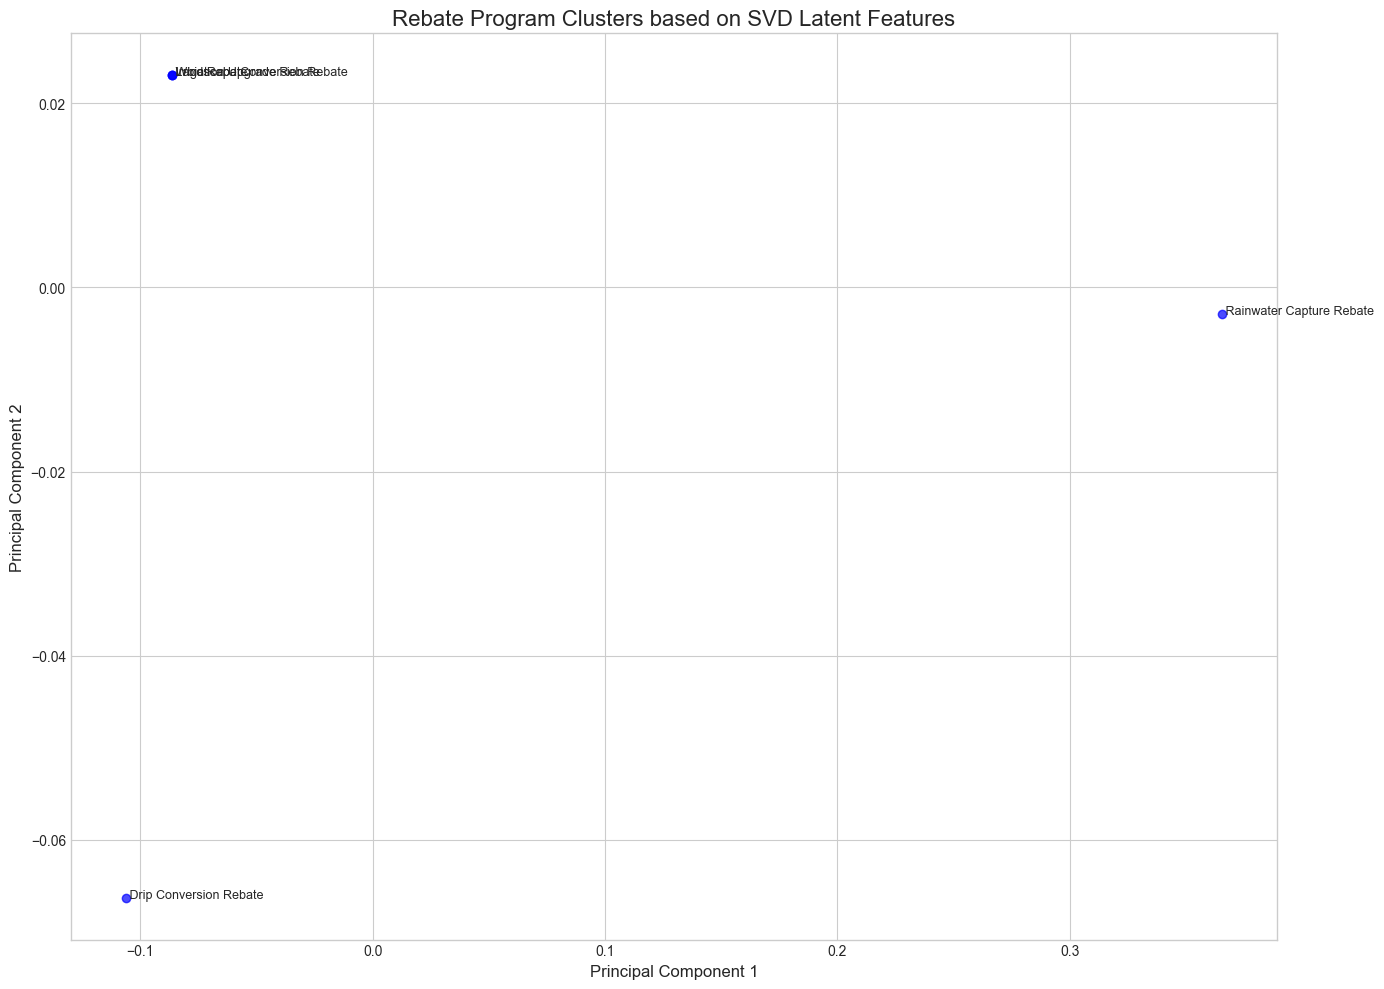


--- Detailed Rebate Positioning Table ---
             Rebate Program                   Internal Name  Principal Component 1  Principal Component 2
     Drip Conversion Rebate      has_drip_conversion_rebate                -0.1063                -0.0663
                Wbic Rebate                 has_wbic_rebate                -0.0865                 0.0231
  Irrigation Upgrade Rebate   has_irrigation_upgrade_rebate                -0.0865                 0.0231
Landscape Conversion Rebate has_landscape_conversion_rebate                -0.0865                 0.0231
   Rainwater Capture Rebate    has_rainwater_capture_rebate                 0.3658                -0.0029

--- Distance Matrix Between Rebates ---
Distance matrix (smaller values = more similar):
                      Wbic Rebate  Landscape Conversion  Irrigation Upgrade R  Rainwater Capture Re  Drip Conversion Reba
Wbic Rebate                 0.000                 0.000                 0.000                 0.453          

In [19]:

print("\n--- Visualizing SVD Latent Features for Rebates ---")

# 1. Extract item (rebate) latent factors from the trained SVD model
# The 'qi' attribute holds the latent feature vectors for all items in the trainset.
# Use the 'svd_model' variable which holds the final trained model
rebate_factors = svd_model.qi

# 2. Map internal IDs back to human-readable rebate names
# The model uses internal, sequential IDs. We need to map them back to our original rebate column names.
raw_to_inner_iid_map = svd_model.trainset._raw2inner_id_items
rebate_names = list(raw_to_inner_iid_map.keys())

# 3. Use PCA to reduce the dimensionality of the latent features to 2D for plotting
pca = PCA(n_components=2)
rebate_factors_2d = pca.fit_transform(rebate_factors)

# 4. Create the visualization
plt.figure(figsize=(14, 10))
plt.scatter(rebate_factors_2d[:, 0], rebate_factors_2d[:, 1], alpha=0.7, c='blue')

# Add labels for each point
for i, name in enumerate(rebate_names):
    # Use the human-readable name from our map
    readable_name = rebate_name_map.get(name, name).replace('has_', '').replace('_', ' ').title()
    plt.text(rebate_factors_2d[i, 0], rebate_factors_2d[i, 1], ' ' + readable_name, fontsize=9)

plt.title('Rebate Program Clusters based on SVD Latent Features', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Create a detailed table showing exact coordinates
print("\n--- Detailed Rebate Positioning Table ---")
coordinates_df = pd.DataFrame({
    'Rebate Program': [rebate_name_map.get(name, name).replace('has_', '').replace('_', ' ').title() for name in rebate_names],
    'Internal Name': rebate_names,
    'Principal Component 1': rebate_factors_2d[:, 0],
    'Principal Component 2': rebate_factors_2d[:, 1]
})

# Sort by PC1 for easier reading
coordinates_df = coordinates_df.sort_values('Principal Component 1')
print(coordinates_df.to_string(index=False, float_format='%.4f'))

# 6. Calculate and display distance matrix
print("\n--- Distance Matrix Between Rebates ---")
# Calculate pairwise distances
distances = pdist(rebate_factors_2d, metric='euclidean')
distance_matrix = squareform(distances)

# Create readable labels
readable_names = [rebate_name_map.get(name, name).replace('has_', '').replace('_', ' ').title()[:20] for name in rebate_names]
distance_df = pd.DataFrame(distance_matrix, index=readable_names, columns=readable_names)

print("Distance matrix (smaller values = more similar):")
print(distance_df.round(3).to_string())

# 7. Identify closest pairs
print("\n--- Closest Rebate Pairs ---")
closest_pairs = []
for i in range(len(rebate_names)):
    for j in range(i+1, len(rebate_names)):
        distance = distance_matrix[i, j]
        pair_info = {
            'rebate_1': rebate_name_map.get(rebate_names[i], rebate_names[i]),
            'rebate_2': rebate_name_map.get(rebate_names[j], rebate_names[j]),
            'distance': distance
        }
        closest_pairs.append(pair_info)

# Sort by distance (closest first)
closest_pairs.sort(key=lambda x: x['distance'])

print("Top 5 most similar rebate pairs:")
for i, pair in enumerate(closest_pairs[:5], 1):
    print(f"{i}. {pair['rebate_1']} <-> {pair['rebate_2']} (distance: {pair['distance']:.4f})")


## 7. Geocoding and City Coordinates Generation

In [20]:

# Generate city coordinates for dashboard mapping
print("=== GEOCODING CITY COORDINATES ===")
print("Generating coordinates for all cities in the dataset...")

def geocode_location(city_name, zip_code=None, retries=3):
    # Geocode a city name or zip code to latitude/longitude coordinates
    geolocator = Nominatim(user_agent="valley_water_rebates_v1.0")
    
    # Try zip code first if available
    if zip_code and str(zip_code) != 'nan' and str(zip_code) != '00nan':
        query = f"{zip_code}, CA, USA"
    else:
        query = f"{city_name}, CA, USA"
    
    for attempt in range(retries):
        try:
            location = geolocator.geocode(query, timeout=10)
            time.sleep(1.1)  # Rate limiting
            
            if location:
                return (location.latitude, location.longitude)
            else:
                print(f"No coordinates found for: {query}")
                return None
                
        except Exception as e:
            print(f"Geocoding attempt {attempt + 1} failed for {query}: {e}")
            if attempt < retries - 1:
                time.sleep(2)  # Wait longer on error
            else:
                return None
    
    return None

# Get unique cities from the cleaned data
unique_cities = df_cleaned['City'].dropna().unique()
print(f"Found {len(unique_cities)} unique cities to geocode")

# Create city coordinates dataframe
city_coords_data = []
failed_geocodes = []

for i, city in enumerate(unique_cities, 1):
    print(f"Geocoding {i}/{len(unique_cities)}: {city}")
    
    # Try to get zip code for this city (use most common one)
    city_zips = df_cleaned[df_cleaned['City'] == city]['Site Zip Code'].dropna()
    zip_code = city_zips.mode().iloc[0] if len(city_zips) > 0 else None
    
    coords = geocode_location(city, zip_code)
    
    if coords:
        city_coords_data.append({
            'city': city,
            'latitude': coords[0],
            'longitude': coords[1],
            'zip_code': zip_code
        })
        print(f"  Success: {coords[0]:.4f}, {coords[1]:.4f}")
    else:
        failed_geocodes.append(city)
        print(f"  Failed to geocode {city}")

# Create city coordinates DataFrame
city_coordinates_df = pd.DataFrame(city_coords_data)
print(f"\nSuccessfully geocoded {len(city_coordinates_df)} out of {len(unique_cities)} cities")
print(f"Failed geocodes: {failed_geocodes}")

# Save city coordinates
city_coordinates_df.to_csv('city_coordinates.csv', index=False)
print("\nSaved city coordinates to 'city_coordinates.csv'")
print(city_coordinates_df.head())


=== GEOCODING CITY COORDINATES ===
Generating coordinates for all cities in the dataset...
Found 17 unique cities to geocode
Geocoding 1/17: Milpitas


  Success: 37.4344, -121.8907
Geocoding 2/17: San Jose


  Success: 37.2159, -121.8625
Geocoding 3/17: Cupertino


  Success: 37.3178, -122.0372
Geocoding 4/17: Mountain View


  Success: 37.3819, -122.0821
Geocoding 5/17: Los Altos Hills


  Success: 37.3845, -122.1124
Geocoding 6/17: Palo Alto


  Success: 37.4222, -122.1351
Geocoding 7/17: Sunnyvale


  Success: 37.3578, -122.0391
Geocoding 8/17: Stanford


  Success: 37.4262, -122.1645
Geocoding 9/17: Los Gatos


  Success: 37.2440, -121.9492
Geocoding 10/17: Saratoga


  Success: 37.2772, -122.0045
Geocoding 11/17: Campbell


  Success: 37.2793, -121.9534
Geocoding 12/17: Morgan Hill


  Success: 37.1359, -121.6676
Geocoding 13/17: Gilroy


  Success: 37.0103, -121.5742
Geocoding 14/17: Santa Clara


  Success: 37.3490, -121.9844
Geocoding 15/17: Los Altos


  Success: 37.3569, -122.0860
Geocoding 16/17: Monte Sereno


  Success: 37.2274, -121.9814
Geocoding 17/17: San Martin


  Success: 37.0857, -121.6060

Successfully geocoded 17 out of 17 cities
Failed geocodes: []

Saved city coordinates to 'city_coordinates.csv'
              city   latitude   longitude zip_code
0         Milpitas  37.434382 -121.890680    95035
1         San Jose  37.215887 -121.862545    95120
2        Cupertino  37.317771 -122.037174    95014
3    Mountain View  37.381912 -122.082065    94040
4  Los Altos Hills  37.384515 -122.112387    94022


## 8. Analytics Data Preparation for Dashboard

In [21]:

# Prepare analytics data for dashboard endpoints
print("=== ANALYTICS DATA PREPARATION ===")
print("Preparing pre-computed analytics for dashboard performance...")

# Define rebate columns for analytics
rebate_columns = [
    'has_wbic_rebate', 'has_irrigation_upgrade_rebate', 'has_landscape_conversion_rebate',
    'has_drip_conversion_rebate', 'has_rainwater_capture_rebate', 'participated_in_graywater'
]

# 1. City-level popularity statistics
print("\n1. Computing city-level rebate popularity...")
city_rebate_counts = df_cleaned.groupby('City').size().reset_index(name='total_rebates')
city_rebate_counts = city_rebate_counts.sort_values('total_rebates', ascending=False)

# Add city popularity by rebate type
city_rebate_details = []
for city in city_rebate_counts['City']:
    city_data = df_cleaned[df_cleaned['City'] == city]
    
    # Count by rebate type
    rebate_counts = {}
    for col in rebate_columns:
        if col in city_data.columns:
            rebate_counts[col] = city_data[col].sum()
    
    # Find most popular rebate
    most_popular = max(rebate_counts.items(), key=lambda x: x[1]) if rebate_counts else ('None', 0)
    
    city_rebate_details.append({
        'city': city,
        'total_rebates': len(city_data),
        'most_popular_rebate': most_popular[0],
        'most_popular_count': most_popular[1],
        'unique_customers': city_data['Site ID'].nunique()
    })

city_popularity_df = pd.DataFrame(city_rebate_details)
print(f"Computed popularity for {len(city_popularity_df)} cities")
print(city_popularity_df.head())

# 2. Site type popularity statistics
print("\n2. Computing site type rebate popularity...")
site_type_rebate_counts = df_cleaned.groupby('Site Type').size().reset_index(name='total_rebates')
site_type_rebate_counts = site_type_rebate_counts.sort_values('total_rebates', ascending=False)

site_type_details = []
for site_type in site_type_rebate_counts['Site Type']:
    site_data = df_cleaned[df_cleaned['Site Type'] == site_type]
    
    # Count by rebate type
    rebate_counts = {}
    for col in rebate_columns:
        if col in site_data.columns:
            rebate_counts[col] = site_data[col].sum()
    
    # Find most popular rebate
    most_popular = max(rebate_counts.items(), key=lambda x: x[1]) if rebate_counts else ('None', 0)
    
    site_type_details.append({
        'site_type': site_type,
        'total_rebates': len(site_data),
        'most_popular_rebate': most_popular[0],
        'most_popular_count': most_popular[1],
        'unique_customers': site_data['Site ID'].nunique()
    })

site_type_popularity_df = pd.DataFrame(site_type_details)
print(f"Computed popularity for {len(site_type_popularity_df)} site types")
print(site_type_popularity_df.head())

# 3. Dashboard summary KPIs
print("\n3. Computing dashboard summary KPIs...")
total_customers = df_cleaned['Site ID'].nunique()
total_rebates = len(df_cleaned)
total_cities = df_cleaned['City'].nunique()
total_site_types = df_cleaned['Site Type'].nunique()
avg_rebates_per_customer = total_rebates / total_customers

# Recent activity (2024-2025)
recent_data = df_cleaned[df_cleaned['Request Date'] >= '2024-01-01']
recent_customers = recent_data['Site ID'].nunique()
recent_rebates = len(recent_data)

dashboard_summary = {
    'total_customers': total_customers,
    'total_rebates': total_rebates,
    'total_cities': total_cities,
    'total_site_types': total_site_types,
    'avg_rebates_per_customer': round(avg_rebates_per_customer, 2),
    'recent_customers_2024_plus': recent_customers,
    'recent_rebates_2024_plus': recent_rebates,
    'data_last_updated': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

print("Dashboard Summary KPIs:")
for key, value in dashboard_summary.items():
    print(f"  {key}: {value}")


=== ANALYTICS DATA PREPARATION ===
Preparing pre-computed analytics for dashboard performance...

1. Computing city-level rebate popularity...
Computed popularity for 17 cities
          city  total_rebates most_popular_rebate  most_popular_count  \
0     San Jose           6827                None                   0   
1    Sunnyvale           1140                None                   0   
2    Palo Alto           1105                None                   0   
3  Santa Clara            911                None                   0   
4    Cupertino            841                None                   0   

   unique_customers  
0              6310  
1              1065  
2              1023  
3               846  
4               761  

2. Computing site type rebate popularity...
Computed popularity for 5 site types
       site_type  total_rebates most_popular_rebate  most_popular_count  \
0  Single Family          13735                None                   0   
1            MFD    

## 9. Model Packaging and Serialization for Deployment

In [22]:

# Package all models and data for deployment
print("=== MODEL PACKAGING FOR DEPLOYMENT ===")
print("Saving all models and supporting data as .pkl files...")

# Create deployment directory
os.makedirs('deployment_artifacts', exist_ok=True)

# 1. Save trained SVD model
print("\n1. Saving trained SVD model...")
with open('deployment_artifacts/trained_svd_model.pkl', 'wb') as f:
    pickle.dump(svd_model, f)
print("Saved: trained_svd_model.pkl")

# 2. Save correlation matrix
print("\n2. Saving correlation matrix...")
with open('deployment_artifacts/correlation_matrix.pkl', 'wb') as f:
    pickle.dump(correlation_matrix, f)
print("Saved: correlation_matrix.pkl")

# 3. Save rebate name mapping
print("\n3. Saving rebate name mapping...")
with open('deployment_artifacts/rebate_name_mapping.pkl', 'wb') as f:
    pickle.dump(rebate_name_map, f)
print("Saved: rebate_name_mapping.pkl")

# 4. Save city popularity data
print("\n4. Saving city popularity data...")
with open('deployment_artifacts/city_popularity.pkl', 'wb') as f:
    pickle.dump(city_popularity_df, f)
print("Saved: city_popularity.pkl")

# 5. Save site type popularity data
print("\n5. Saving site type popularity data...")
with open('deployment_artifacts/site_type_popularity.pkl', 'wb') as f:
    pickle.dump(site_type_popularity_df, f)
print("Saved: site_type_popularity.pkl")

# 6. Save dashboard summary KPIs
print("\n6. Saving dashboard summary KPIs...")
with open('deployment_artifacts/dashboard_summary.pkl', 'wb') as f:
    pickle.dump(dashboard_summary, f)
print("Saved: dashboard_summary.pkl")

# 7. Save supporting data for API
print("\n7. Saving supporting data...")
# Save rebate columns list
with open('deployment_artifacts/rebate_columns.pkl', 'wb') as f:
    pickle.dump(rebate_columns, f)
print("Saved: rebate_columns.pkl")

# Save unique cities and site types for filtering
with open('deployment_artifacts/unique_cities.pkl', 'wb') as f:
    pickle.dump(list(df_cleaned['City'].dropna().unique()), f)
print("Saved: unique_cities.pkl")

with open('deployment_artifacts/unique_site_types.pkl', 'wb') as f:
    pickle.dump(list(df_cleaned['Site Type'].dropna().unique()), f)
print("Saved: unique_site_types.pkl")

# 8. Copy key data files to deployment directory
print("\n8. Copying data files...")
import shutil
shutil.copy('cleaned_master_data.csv', 'deployment_artifacts/cleaned_master_data.csv')
print("Copied: cleaned_master_data.csv")

if os.path.exists('city_coordinates.csv'):
    shutil.copy('city_coordinates.csv', 'deployment_artifacts/city_coordinates.csv')
    print("Copied: city_coordinates.csv")

print("\n=== DEPLOYMENT PACKAGING COMPLETE ===")
print("All required files saved to 'deployment_artifacts/' directory:")
for file in os.listdir('deployment_artifacts'):
    file_path = os.path.join('deployment_artifacts', file)
    size_mb = os.path.getsize(file_path) / (1024 * 1024)
    print(f"  {file} ({size_mb:.2f} MB)")

print("\nReady for FastAPI deployment!")


=== MODEL PACKAGING FOR DEPLOYMENT ===
Saving all models and supporting data as .pkl files...

1. Saving trained SVD model...
Saved: trained_svd_model.pkl

2. Saving correlation matrix...
Saved: correlation_matrix.pkl

3. Saving rebate name mapping...
Saved: rebate_name_mapping.pkl

4. Saving city popularity data...
Saved: city_popularity.pkl

5. Saving site type popularity data...
Saved: site_type_popularity.pkl

6. Saving dashboard summary KPIs...
Saved: dashboard_summary.pkl

7. Saving supporting data...
Saved: rebate_columns.pkl
Saved: unique_cities.pkl
Saved: unique_site_types.pkl

8. Copying data files...
Copied: cleaned_master_data.csv
Copied: city_coordinates.csv

=== DEPLOYMENT PACKAGING COMPLETE ===
All required files saved to 'deployment_artifacts/' directory:
  dashboard_summary.pkl (0.00 MB)
  unique_site_types.pkl (0.00 MB)
  correlation_matrix.pkl (0.00 MB)
  site_type_popularity.pkl (0.00 MB)
  city_coordinates.csv (0.00 MB)
  rebate_columns.pkl (0.00 MB)
  unique_citie